## Test env for AI model to generate Browinan Motion for stock price prediction

In [2]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import alpaca_trade_api as tradeapi
import os
from dotenv import load_dotenv
from alpaca_trade_api.rest import TimeFrame
import datetime as dt_
import pytz
from time import sleep
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm
import xgboost as xgb

In [3]:
load_dotenv()
API_KEY = os.getenv("ALPACA_API_KEY")
SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
END_POINT = os.getenv("ALPACA_END_POINT")

In [4]:
api = tradeapi.REST(API_KEY, SECRET_KEY, END_POINT)

In [5]:
def get_stocks_for_train(tickers:list[str], start:str, end:str, timeframe:str = '1hour')->pd.DataFrame:
    df_main = pd.DataFrame({'timestamp': [], 'internal_index': [], 'ticker': [], 'price': [], 'dprice': [], 'dreturn': [], 'trade_count': [], 'volume': [], 'next_vol': [], 'next_tc': [], 'RSI': [], 'Stoch_K': [], 'Stoch_D': [], 'dEMA': [], 'dSMA': [], 'dBBL': [], 'dBBM': [], 'dBBU': [], 'dBBB': [], 'dBBP': []})

    for ticker in tickers:
        bars = api.get_bars(ticker, start=start, end=end, timeframe=timeframe).df
        data = pd.DataFrame(bars)
        data.reset_index(inplace=True)
        data = data[['timestamp', 'high', 'low', 'close', 'trade_count', 'volume']]
        data.reset_index(inplace=True)
        for i in range(1, len(data)-1):
            data.loc[i, 'dprice'] = 100*(data.loc[i, 'close'] / data.loc[i-1, 'close'] - 1)
            data.loc[i, 'dreturn'] = 100*(data.loc[i+1, 'close'] / data.loc[i, 'close'] - 1)
            data.loc[i, 'next_vol'] = data.loc[i+1, 'volume']
            data.loc[i, 'next_tc'] = data.loc[i+1, 'trade_count']

        data = data.dropna()
        data['RSI'] = ta.rsi(data['close'], 14)
        stoch = ta.stoch(data['high'], data['low'], data['close'], 14)
        data['Stoch_K'] = stoch['STOCHk_14_3_3']
        data['Stoch_D'] = stoch['STOCHd_14_3_3']
        data['dEMA'] = ta.sma(data['dprice'], 14)
        data['dSMA'] = ta.ema(data['dprice'], 14)
        dBB = ta.bbands(data['dprice'], 14)
        data['dBBL'] = dBB['BBL_14_2.0']
        data['dBBM'] = dBB['BBM_14_2.0']
        data['dBBU'] = dBB['BBU_14_2.0']
        data['dBBB'] = dBB['BBB_14_2.0']
        data['dBBP'] = dBB['BBP_14_2.0']
        

        df = data[['timestamp', 'trade_count', 'volume', 'next_vol', 'next_tc', 'dprice', 'dreturn', 'RSI', 'Stoch_K', 'Stoch_D', 'dEMA', 'dSMA', 'dBBL', 'dBBM', 'dBBU', 'dBBB', 'dBBP']]
        df.reset_index(inplace=True)
        df['ticker'] = ticker
        df['price'] = data['close']

        df = df.dropna()

        df_main = pd.concat([df_main, df],axis=0)

    return df_main


In [7]:
tickers = "AAPL,JNJ,MSFT,MSFT,WMT,V,XOM,DIS,JCI,KO".split(",")

data = get_stocks_for_train(tickers, start='2024-01-01', end='2024-09-30', timeframe='1hour')
data

C:\Users\naths\AppData\Local\Temp\ipykernel_29772\2772891911.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ticker'] = ticker
C:\Users\naths\AppData\Local\Temp\ipykernel_29772\2772891911.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = data['close']
C:\Users\naths\AppData\Local\Temp\ipykernel_29772\2772891911.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA co

,timestamp,internal_index,ticker,price,dprice,dreturn,trade_count,volume,next_vol,next_tc,...,Stoch_K,Stoch_D,dEMA,dSMA,dBBL,dBBM,dBBU,dBBB,dBBP,index
17,2024-01-03 11:00:00+00:00,NaN,AAPL,184.7300,0.146159,-0.372973,682.0,21380.0,89306.0,2988.0,...,14.461979,13.262405,-0.117807,-0.110060,-0.928776,-0.117807,0.693162,-1376.775459,0.662747,18.0
18,2024-01-03 12:00:00+00:00,NaN,AAPL,185.0000,-0.372973,0.184472,2988.0,89306.0,395721.0,7701.0,...,15.330896,13.780325,-0.084449,-0.145115,-0.807507,-0.084449,0.638609,-1712.405164,0.300484,19.0
19,2024-01-03 13:00:00+00:00,NaN,AAPL,184.3100,0.184472,0.065042,7701.0,395721.0,9882363.0,104617.0,...,19.432058,16.408311,-0.047147,-0.101171,-0.767963,-0.047147,0.673669,-3057.753769,0.660664,20.0
20,2024-01-03 14:00:00+00:00,NaN,AAPL,184.6500,0.065042,-0.492558,104617.0,9882363.0,9495059.0,206132.0,...,23.407322,19.390092,-0.075328,-0.079009,-0.743634,-0.075328,0.592979,-1774.401617,0.605019,21.0
21,2024-01-03 15:00:00+00:00,NaN,AAPL,184.7701,-0.492558,-0.190362,206132.0,9495059.0,5895725.0,88674.0,...,24.768916,22.536099,-0.077375,-0.134149,-0.750588,-0.077375,0.595838,-1740.134679,0.191640,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,2024-09-30 17:00:00+00:00,NaN,KO,71.7861,0.072855,-0.095214,9116.0,669583.0,934341.0,12569.0,...,26.111111,43.645358,0.005953,-0.008194,-0.333707,0.005953,0.345614,11410.470758,0.598483,2790.0
2790,2024-09-30 18:00:00+00:00,NaN,KO,71.8384,-0.095214,0.111467,12569.0,934341.0,2466549.0,25969.0,...,21.209150,30.569406,-0.001843,-0.019797,-0.345401,-0.001843,0.341715,-37290.591263,0.364112,2791.0
2791,2024-09-30 19:00:00+00:00,NaN,KO,71.7700,0.111467,0.097425,25969.0,2466549.0,9962204.0,214.0,...,25.385621,24.235294,0.006119,-0.002295,-0.342371,0.006119,0.354610,11389.809261,0.651149,2792.0
2792,2024-09-30 20:00:00+00:00,NaN,KO,71.8500,0.097425,0.000000,214.0,9962204.0,236.0,3.0,...,30.718954,25.771242,0.021784,0.011001,-0.321967,0.021784,0.365535,3155.962885,0.610023,2793.0


In [8]:
df = data["timestamp,ticker,price,dprice,dreturn,trade_count,volume,next_vol,next_tc,RSI,Stoch_K,Stoch_D,dEMA,dSMA,dBBL,dBBM,dBBU,dBBB,dBBP".split(",")]
df.reset_index(inplace=True)
df

,index,timestamp,ticker,price,dprice,dreturn,trade_count,volume,next_vol,next_tc,RSI,Stoch_K,Stoch_D,dEMA,dSMA,dBBL,dBBM,dBBU,dBBB,dBBP
0,17,2024-01-03 11:00:00+00:00,AAPL,184.7300,0.146159,-0.372973,682.0,21380.0,89306.0,2988.0,31.570917,14.461979,13.262405,-0.117807,-0.110060,-0.928776,-0.117807,0.693162,-1376.775459,0.662747
1,18,2024-01-03 12:00:00+00:00,AAPL,185.0000,-0.372973,0.184472,2988.0,89306.0,395721.0,7701.0,27.603090,15.330896,13.780325,-0.084449,-0.145115,-0.807507,-0.084449,0.638609,-1712.405164,0.300484
2,19,2024-01-03 13:00:00+00:00,AAPL,184.3100,0.184472,0.065042,7701.0,395721.0,9882363.0,104617.0,32.129570,19.432058,16.408311,-0.047147,-0.101171,-0.767963,-0.047147,0.673669,-3057.753769,0.660664
3,20,2024-01-03 14:00:00+00:00,AAPL,184.6500,0.065042,-0.492558,104617.0,9882363.0,9495059.0,206132.0,33.706316,23.407322,19.390092,-0.075328,-0.079009,-0.743634,-0.075328,0.592979,-1774.401617,0.605019
4,21,2024-01-03 15:00:00+00:00,AAPL,184.7701,-0.492558,-0.190362,206132.0,9495059.0,5895725.0,88674.0,28.334435,24.768916,22.536099,-0.077375,-0.134149,-0.750588,-0.077375,0.595838,-1740.134679,0.191640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26388,2789,2024-09-30 17:00:00+00:00,KO,71.7861,0.072855,-0.095214,9116.0,669583.0,934341.0,12569.0,51.743639,26.111111,43.645358,0.005953,-0.008194,-0.333707,0.005953,0.345614,11410.470758,0.598483
26389,2790,2024-09-30 18:00:00+00:00,KO,71.8384,-0.095214,0.111467,12569.0,934341.0,2466549.0,25969.0,49.425063,21.209150,30.569406,-0.001843,-0.019797,-0.345401,-0.001843,0.341715,-37290.591263,0.364112
26390,2791,2024-09-30 19:00:00+00:00,KO,71.7700,0.111467,0.097425,25969.0,2466549.0,9962204.0,214.0,52.126991,25.385621,24.235294,0.006119,-0.002295,-0.342371,0.006119,0.354610,11389.809261,0.651149
26391,2792,2024-09-30 20:00:00+00:00,KO,71.8500,0.097425,0.000000,214.0,9962204.0,236.0,3.0,54.421507,30.718954,25.771242,0.021784,0.011001,-0.321967,0.021784,0.365535,3155.962885,0.610023


In [9]:
feature_columns = "dprice,trade_count,volume,RSI,Stoch_K,Stoch_D,dEMA,dSMA,dBBL,dBBM,dBBU,dBBB,dBBP".split(",")
target_column = "dreturn"

X_features = df[feature_columns].values  # Convert to numpy for easy slicing
Y_target = df[target_column].values
Y_vol = df['next_vol'].values
Y_tc = df['next_tc'].values

# Parameters
window_size = 14  # Each input contains 14 rows

# Prepare X and Y with sliding windows
X = []
Y1 = []
Y2 = []
Y3 = []

for i in range(len(df) - window_size + 1):
    X.append(X_features[i:i + window_size])  # 14 rows of features
    Y1.append(Y_target[i + window_size - 1])  # 14th value of 'dreturn'
    Y2.append(Y_vol[i + window_size - 1])  # 14th value of 'dreturn'
    Y3.append(Y_tc[i + window_size - 1])  # 14th value of 'dreturn'

X = np.array(X)  # Shape: (num_samples, window_size, num_features)
Y1 = np.array(Y1)  # Shape: (num_samples,)
Y2 = np.array(Y2)  # Shape: (num_samples,)
Y3 = np.array(Y3)  # Shape: (num_samples,)

# Ensure data dimensions
print("Shape of X:", X.shape)  # (num_samples, 14, num_features)
print("Shape of Y:", Y1.shape)  # (num_samples,)

# Flatten X for XGBoost (XGBoost expects 2D inputs)
X_flat = X.reshape(X.shape[0], -1)  # Shape: (num_samples, 14 * num_features)

# Train the XGBoost regressor
model_dprice = xgb.XGBRegressor()
model_dprice.fit(X_flat, Y1)

model_vol = xgb.XGBRegressor()
model_vol.fit(X_flat,Y2)

model_tc = xgb.XGBRegressor()
model_tc.fit(X_flat,Y3)

Shape of X: (26380, 14, 13)
Shape of Y: (26380,)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
predictions = model_dprice.predict(X_flat[21712].reshape(1,-1))[0]  # Predict for the first 5 packets
predictions

-0.0029169037

In [11]:
def get_stocks(tickers: list[str], timeframe: str, start: str, end: str) -> pd.DataFrame:
    """
    timeframe: 1min | 5min | 15min | 1hour | 1day | 1week
    """
    stock_dfs = []
    
    for ticker in tickers:
        bars = api.get_bars(ticker, timeframe, start, end).df
        bars.reset_index(inplace=True)
        stock_df = pd.DataFrame({
            'timestamp': bars['timestamp'],
            ticker: bars['close'],
            f'{ticker}:low': bars['low'],
            f'{ticker}:high': bars['high'],
            f'{ticker}:volume': bars['volume'],
            f'{ticker}:trade_count': bars['trade_count']
        })
        stock_dfs.append(stock_df)

    merged_df = stock_dfs[0]
    
    for stock_df in stock_dfs[1:]:
        merged_df = pd.merge(merged_df, stock_df, on='timestamp', how='inner')

    merged_df.reset_index(drop=True, inplace=True)
    
    return merged_df

In [12]:
tickers = ['AAPL','XOM']

stocks_df = get_stocks(tickers, '1hour', '2024-10-01', '2024-12-31')
stocks = stocks_df.copy()
stocks

,timestamp,AAPL,AAPL:low,AAPL:high,AAPL:volume,AAPL:trade_count,XOM,XOM:low,XOM:high,XOM:volume,XOM:trade_count
0,2024-10-01 08:00:00+00:00,233.0900,233.0800,233.37,13482,411,115.96,115.9600,117.15,2728,63
1,2024-10-01 09:00:00+00:00,233.4200,233.2300,233.42,7128,180,116.08,116.0000,116.09,1528,20
2,2024-10-01 10:00:00+00:00,233.0000,233.0000,233.56,37477,706,116.50,116.4400,116.50,1315,15
3,2024-10-01 11:00:00+00:00,230.3200,229.4400,233.10,657259,8592,116.69,116.5400,117.00,6121,71
4,2024-10-01 12:00:00+00:00,230.0000,229.4000,233.47,571654,9058,116.60,116.4400,116.88,76903,135
...,...,...,...,...,...,...,...,...,...,...,...
982,2024-12-31 20:00:00+00:00,250.3800,249.5000,251.08,9262852,86800,107.63,107.3600,107.90,3500364,31959
983,2024-12-31 21:00:00+00:00,250.4300,250.2000,250.67,11672216,1894,107.57,107.5700,107.63,2474281,128
984,2024-12-31 22:00:00+00:00,250.4330,250.4100,250.50,395180,302,107.20,107.2000,107.57,7745,82
985,2024-12-31 23:00:00+00:00,250.4219,250.4209,250.49,2007,80,107.56,107.5582,107.56,5200,3


In [13]:
stocks.loc[0, 'AAPL']

233.09

In [14]:
for ticker in tickers:
    for i in range(1, len(stocks)-1):
        stocks.loc[stocks.index[i], f'{ticker}:dprice'] = 100 * (stocks.loc[stocks.index[i], ticker] / stocks.loc[stocks.index[i - 1], ticker] - 1)
        
    stocks = stocks.dropna()
    stocks[f'{ticker}:RSI'] = ta.rsi(stocks[ticker], 14)
    stoch = ta.stoch(stocks[f'{ticker}:high'], stocks[f'{ticker}:low'], stocks[ticker], 14)
    stocks[f'{ticker}:Stoch_K'] = stoch['STOCHk_14_3_3']
    stocks[f'{ticker}:Stoch_D'] = stoch['STOCHd_14_3_3']
    stocks[f'{ticker}:dEMA'] = ta.sma(stocks[f'{ticker}:dprice'], 14)
    stocks[f'{ticker}:dSMA'] = ta.ema(stocks[f'{ticker}:dprice'], 14)
    dBB = ta.bbands(stocks[f'{ticker}:dprice'], 14)
    stocks[f'{ticker}:dBBL'] = dBB['BBL_14_2.0']
    stocks[f'{ticker}:dBBM'] = dBB['BBM_14_2.0']
    stocks[f'{ticker}:dBBU'] = dBB['BBU_14_2.0']
    stocks[f'{ticker}:dBBB'] = dBB['BBB_14_2.0']
    stocks[f'{ticker}:dBBP'] = dBB['BBP_14_2.0']

stocks = stocks.dropna()
stocks

C:\Users\naths\AppData\Local\Temp\ipykernel_29772\3906843855.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks[f'{ticker}:RSI'] = ta.rsi(stocks[ticker], 14)
C:\Users\naths\AppData\Local\Temp\ipykernel_29772\3906843855.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks[f'{ticker}:Stoch_K'] = stoch['STOCHk_14_3_3']
C:\Users\naths\AppData\Local\Temp\ipykernel_29772\3906843855.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,timestamp,AAPL,AAPL:low,AAPL:high,AAPL:volume,AAPL:trade_count,XOM,XOM:low,XOM:high,XOM:volume,...,XOM:RSI,XOM:Stoch_K,XOM:Stoch_D,XOM:dEMA,XOM:dSMA,XOM:dBBL,XOM:dBBM,XOM:dBBU,XOM:dBBB,XOM:dBBP
35,2024-10-03 11:00:00+00:00,225.530,225.150,226.090,57907,1043,121.79,121.2100,121.8800,20213,...,52.740807,60.505725,56.173664,-0.028775,0.009551,-0.651353,-0.028775,0.593804,-4327.269707,0.549495
36,2024-10-03 12:00:00+00:00,225.210,224.790,226.370,190054,3262,121.90,121.5000,122.1900,34825,...,55.464423,70.279147,61.915568,0.039006,0.020320,-0.381144,0.039006,0.459157,2154.267046,0.561065
37,2024-10-03 13:00:00+00:00,226.305,224.570,226.700,3359764,48613,121.47,120.9290,122.1645,1322017,...,44.635195,71.832077,67.538983,0.021469,-0.029422,-0.440089,0.021469,0.483027,4299.758247,0.094615
38,2024-10-03 14:00:00+00:00,224.340,224.250,226.805,5037911,117638,122.66,121.4200,123.1700,3340202,...,65.001007,77.358171,73.156465,0.111498,0.105123,-0.534139,0.111498,0.757135,1158.116746,1.172334
39,2024-10-03 15:00:00+00:00,225.130,224.282,225.250,3074644,136225,122.12,121.8900,122.6900,1421386,...,55.096682,70.431281,73.207176,0.101344,0.032408,-0.573548,0.101344,0.776236,1331.885225,0.098762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,2024-12-31 18:00:00+00:00,249.880,249.430,250.740,3270596,44365,107.55,107.2100,107.6400,759377,...,66.691676,89.592651,88.933562,0.092485,0.126750,-0.496970,0.092485,0.681939,1274.707375,0.476795
981,2024-12-31 19:00:00+00:00,250.420,249.670,250.430,2472924,39816,107.80,107.4229,107.8400,1203052,...,69.146878,97.642187,91.954900,0.122779,0.140843,-0.448460,0.122779,0.694018,930.517045,0.595994
982,2024-12-31 20:00:00+00:00,250.380,249.500,251.080,9262852,86800,107.63,107.3600,107.9000,3500364,...,65.605531,93.734336,93.656392,0.127355,0.101037,-0.433707,0.127355,0.688416,881.101401,0.245969
983,2024-12-31 21:00:00+00:00,250.430,250.200,250.670,11672216,1894,107.57,107.5700,107.6300,2474281,...,64.352822,90.278069,93.884864,0.121684,0.080133,-0.445032,0.121684,0.688400,931.456704,0.343457


In [15]:
X_data = stocks[-28:-14]
params = "high,low,dprice,trade_count,volume,RSI,Stoch_K,Stoch_D,dEMA,dSMA,dBBL,dBBM,dBBU,dBBB,dBBP".split(",")
ticker = 'AAPL'

X_for_MC = pd.DataFrame()
X_for_MC['price'] = X_data[ticker]

for param in params:
    X_for_MC[param] = X_data[f'{ticker}:{param}']

X_for_MC

,price,high,low,dprice,trade_count,volume,RSI,Stoch_K,Stoch_D,dEMA,dSMA,dBBL,dBBM,dBBU,dBBB,dBBP
957,254.77,254.9405,254.720,-0.070602,293,20764,36.768292,28.841246,32.984516,-0.110960,-0.070088,-0.760670,-0.110960,0.538751,-1171.075895,0.531058
958,254.77,254.9783,254.770,0.000000,280,14673,36.768292,27.105666,29.896206,-0.114272,-0.060743,-0.761207,-0.114272,0.532663,-1132.274277,0.588318
959,254.40,255.0200,254.310,-0.145229,911,24850,34.664950,24.298111,26.748341,-0.126025,-0.072008,-0.768791,-0.126025,0.516741,-1020.062635,0.485061
960,252.90,254.6100,252.880,-0.589623,1896,61471,27.737442,15.668522,22.357433,-0.177243,-0.141023,-0.844856,-0.177243,0.490369,-753.328131,0.191154
961,252.29,255.2400,252.010,-0.241202,6318,204301,25.505214,8.334696,16.100443,-0.174912,-0.154380,-0.841386,-0.174912,0.491561,-762.065599,0.450268
962,251.27,253.0000,250.890,-0.404297,80129,4786778,22.276859,3.689734,9.230984,-0.149915,-0.187703,-0.750599,-0.149915,0.450770,-801.367836,0.288257
963,251.69,252.1700,250.750,0.167151,80622,4680602,26.407520,9.155803,7.060078,-0.091500,-0.140389,-0.643095,-0.091500,0.460094,-1205.666894,0.734458
964,252.54,252.6488,251.060,0.337717,53358,3040898,34.046909,18.358673,10.401404,-0.030536,-0.076641,-0.569602,-0.030536,0.508530,-3530.721954,0.841566
965,253.41,253.4700,252.350,0.344500,43055,2539682,40.818576,31.912374,19.808950,-0.030289,-0.020489,-0.570038,-0.030289,0.509461,-3564.033937,0.847187
966,253.14,253.4100,252.500,-0.106547,37341,1971416,39.464340,40.497336,30.256128,-0.060352,-0.031964,-0.565765,-0.060352,0.445060,-1674.877501,0.454300


## Monte Carlo Simulation of Stock Price Paths to find $\mu$ and $\sigma$

In [16]:
N = 1
T = 14
paths = []

for n in range(N):
    prev_path = X_for_MC.copy()
    prev_path.reset_index(inplace=True)        

    pred_path = []
    for t in range(T):
        params_model = "dprice,trade_count,volume,RSI,Stoch_K,Stoch_D,dEMA,dSMA,dBBL,dBBM,dBBU,dBBB,dBBP".split(",")
        params_df = "high,low,dprice,trade_count,volume,RSI,Stoch_K,Stoch_D,dEMA,dSMA,dBBL,dBBM,dBBU,dBBB,dBBP".split(",")

        X_features = prev_path[params_model].values 

        # Prepare X and Y with sliding windows
        X = []
        X.append(X_features[0:T])  # 14 rows of features
        X = np.array(X)
        X_flat = X.reshape(X.shape[0], -1)

        dprice = model_dprice.predict(X_flat[0].reshape(1,-1))[0] / 100

        close = (1 + dprice)*prev_path.iloc[-1]['price']
        sd = np.mean(np.array(prev_path['high']) - np.array(prev_path['low'])) / 2
        high = close + sd
        low = close - sd

        pred_path.append(close)
        
        new_vol = model_vol.predict(X_flat[0].reshape(1,-1))[0]
        new_tc = model_tc.predict(X_flat[0].reshape(1,-1))[0]

        dprice = 100*(close / prev_path.iloc[-1]['price'] - 1)

        new_df = {'price': close, 'high':high, 'low':low, 'dprice': dprice, 'volume': new_vol, 'trade_count': new_tc}
        new_df = pd.DataFrame([new_df])
        cc_df = pd.concat([prev_path["price,low,high,dprice,trade_count,volume".split(",")], new_df], axis=0)
        cc_df.reset_index(inplace=True)
        del cc_df['index']
        cc_df = pd.DataFrame(cc_df[-14:])

        stoch_df = cc_df.copy()

        rows_to_fill = 4
        if rows_to_fill > 0:
            empty_rows = pd.DataFrame(0, columns=stoch_df.columns, index=range(rows_to_fill))
            stoch_df = pd.concat([empty_rows, stoch_df], ignore_index=True)

        stoch = ta.stoch(
            high=stoch_df["high"],
            low=stoch_df["low"],
            close=stoch_df["price"],
            k=14
        )

        cc_df['RSI'] = ta.rsi(stoch_df['price'], 14)

        cc_df['Stoch_K'] = np.array(stoch['STOCHk_14_3_3'])[-1]
        cc_df['Stoch_D'] = np.array(stoch['STOCHd_14_3_3'])[-1]

        cc_df['dEMA'] = ta.sma(cc_df['dprice'], 14)
        cc_df['dSMA'] = ta.ema(cc_df['dprice'], 14)

        dBB = ta.bbands(cc_df['dprice'], 14)
        cc_df['dBBL'] = dBB['BBL_14_2.0']
        cc_df['dBBM'] = dBB['BBM_14_2.0']
        cc_df['dBBU'] = dBB['BBU_14_2.0']
        cc_df['dBBB'] = dBB['BBB_14_2.0']
        cc_df['dBBP'] = dBB['BBP_14_2.0']


        new_row = pd.DataFrame([cc_df.iloc[-1]])
        prev_path = pd.concat([prev_path, new_row], axis=0)[-14:]
        prev_path.reset_index(drop=True, inplace=True)
     
    paths.append(pred_path)

paths


[[252.18117622851116,
  253.14958629986828,
  254.32766566124585,
  254.34792611043073,
  254.83804216696856,
  253.4875280565583,
  253.2290311244803,
  251.2749874532769,
  250.54585320186496,
  249.24966239869872,
  249.16228717660275,
  249.16009371264173,
  249.09691561577733,
  249.71800877440327]]

In [17]:
rsdf = pd.DataFrame({'pred_price': paths[0], 'true_price': stocks[-14:]['AAPL']})

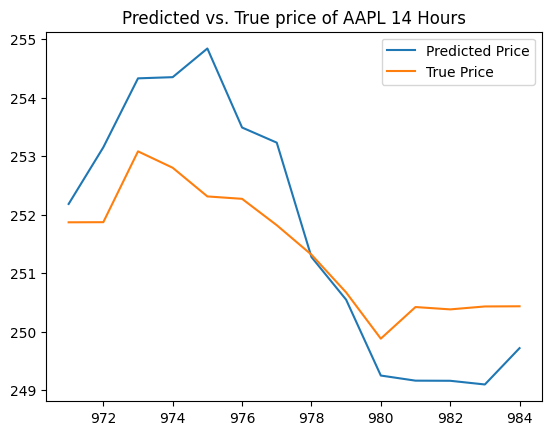

In [18]:
plt.plot(rsdf.index, rsdf['pred_price'], label='Predicted Price')
plt.plot(rsdf.index, rsdf['true_price'], label='True Price')
plt.legend()
plt.title('Predicted vs. True price of AAPL 14 Hours')
plt.show()

In [19]:
model_dprice.save_model('model_dprice.json')
model_vol.save_model('model_vol.json')
model_tc.save_model('model_tc.json')